# Binary classification model training and predictions using Scikit-Learn and Azure ML
_**This notebook showcases the training/creation of a Binary classification model training and predictions using Scikit-Learn and Azure ML.**_


In [62]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from azureml.core import Workspace, Dataset

### Load the IBM employee attrition data created before

Note: as you are now accessing the workspace, the Notebook needs to be authenticated for access through device authentication. Hence, you will be prompted with a device login like so: 

    Performing interactive authentication. Please follow the instructions on the terminal.
    To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code ARQPFR4B4 to authenticate.
    
Please follow these instructions in a new browser tab.

In [63]:
# get the IBM employee attrition dataset from the workspace
ws = Workspace.from_config()
attritionData = ws.datasets['IBM-Employee-Attrition'].to_pandas_dataframe()
attritionData.head()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Age  Attrition     BusinessTravel  DailyRate              Department  \
0   41          1      Travel_Rarely       1102                   Sales   
1   49          0  Travel_Frequently        279  Research & Development   
2   37          1      Travel_Rarely       1373  Research & Development   
3   33          0  Travel_Frequently       1392  Research & Development   
4   27          0      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

## Clean up the initial dataset

In [64]:
# Dropping Employee count as all values are 1 and hence attrition is independent of this feature
attritionData = attritionData.drop(['EmployeeCount'], axis=1)
# Dropping Employee Number since it is merely an identifier
attritionData = attritionData.drop(['EmployeeNumber'], axis=1)

attritionData = attritionData.drop(['Over18'], axis=1)

# Since all values are 80
attritionData = attritionData.drop(['StandardHours'], axis=1)
target = attritionData["Attrition"]

attritionXData = attritionData.drop(['Attrition'], axis=1)

## Split in Train and Test datasets (DataFrames)

In [65]:
# Split data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(attritionXData, 
                                                    target, 
                                                    test_size = 0.2,
                                                    random_state=0,
                                                    stratify=target)

## Transform data

In [66]:
# Collect the categorical and numerical column names in separate lists
categorical = []
for col, value in attritionXData.iteritems():
    if value.dtype == 'object':
        categorical.append(col)
        
numerical = attritionXData.columns.difference(categorical)

### Transform raw features
We can explain raw features by either using a sklearn.compose.ColumnTransformer or a list of fitted transformer tuples. The cell below uses sklearn.compose.ColumnTransformer. In case you want to run the example with the list of fitted transformer tuples, comment the cell below and uncomment the cell that follows after.

## Create data processing pipelines

In [67]:
from sklearn.compose import ColumnTransformer

# We create the transformations pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transforms_pipeline = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

## Add classifier algorithm (SVC: Support Vector Classifier) to the pipeline

In [68]:
# Append classifier to Scikit-Learn transformations pipeline.
# Now we have a full Scikit-Learn prediction pipeline.
model_pipeline = Pipeline(steps=[('preprocessor', transforms_pipeline),
                      ('classifier', SVC(kernel='linear', C = 1.0, probability=True))])

## Train the SVM (Support Vector Machine) Classifier Model

In [69]:
model = model_pipeline.fit(x_train, y_train)

## Make Predictions and calculate Accuracy metric

In [70]:
from sklearn.metrics import accuracy_score

# Make Multiple Predictions
y_predictions = model.predict(x_test)

print('Accuracy:')
accuracy_score(y_test, y_predictions)



Accuracy:


0.8809523809523809

## Confusion Matrix

[[244   3]
 [ 32  15]]


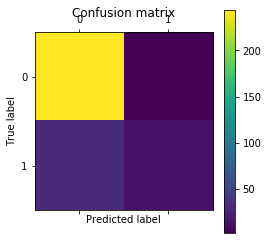

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_predictions)

print(cm)

# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [72]:
# One Prediction
instance_num = 6
# Get the prediction for the first member of the test set and explain why model made that prediction
prediction_value = model.predict(x_test)[instance_num]

print("One Prediction: ")
print(prediction_value)

print(y_predictions[:20])

x_test.head(20)

One Prediction: 
1
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


Age BusinessTravel  DailyRate              Department  DistanceFromHome  \
899    49  Travel_Rarely       1098  Research & Development                 4   
610    27  Travel_Rarely        269  Research & Development                 5   
667    41  Travel_Rarely       1085  Research & Development                 2   
857    44  Travel_Rarely       1097  Research & Development                10   
1063   29  Travel_Rarely       1246                   Sales                19   
1022   37     Non-Travel       1413  Research & Development                 5   
665    47  Travel_Rarely       1454                   Sales                 2   
840    35  Travel_Rarely        982  Research & Development                 1   
796    25  Travel_Rarely       1219  Research & Development                 4   
1221   45     Non-Travel       1238  Research & Development                 1   
149    19  Travel_Rarely       1181  Research & Development                 3   
1139   32  Travel_Rarely        634  Research & Development                 5   
1420   41  Travel_Rarely        642  Research & Development                 1   
322    32  Travel_Rarely       1018  Research & Development                 2   
777    21  Travel_Rarely       1334  Research & Development                10   
47     37  Travel_Rarely        408  Research & Development                19   
1049   30  Travel_Rarely       1358                   Sales                16   
1403   39  Travel_Rarely        119                   Sales                15   
87     51  Travel_Rarely        432  Research & Development                 9   
1331   48  Travel_Rarely       1224  Research & Development                10   

      Education    EducationField  EnvironmentSatisfaction  Gender  \
899           2           Medical                        1    Male   
610           1  Technical Degree                        3    Male   
667           4     Life Sciences                        2  Female   
857           4     Life Sciences                        3    Male   
1063          3     Life Sciences                        3    Male   
1022          2  Technical Degree                        3    Male   
665           4     Life Sciences                        4  Female   
840           4           Medical                        4    Male   
796           1  Technical Degree                        4    Male   
1221          1     Life Sciences                        3    Male   
149           1           Medical                        2  Female   
1139          4             Other                        2  Female   
1420          3     Life Sciences                        4    Male   
322           4           Medical                        1  Female   
777           3     Life Sciences                        3  Female   
47            2     Life Sciences                        2    Male   
1049          1     Life Sciences                        4    Male   
1403          4         Marketing                        2    Male   
87            4     Life Sciences                        4    Male   
1331          3     Life Sciences                        4    Male   

      HourlyRate  ...  PerformanceRating  RelationshipSatisfaction  \
899           85  ...                  3                         3   
610           42  ...                  3                         2   
667           57  ...                  3                         3   
857           96  ...                  3                         3   
1063          77  ...                  3                         3   
1022          84  ...                  3                         1   
665           65  ...                  3                         1   
840           58  ...                  3                         2   
796           32  ...                  3                         2   
1221          74  ...                  4                         4   
149           79  ...                  3                       

In [73]:
y_test.head(5)

899     0
610     0
667     1
857     1
1063    0
Name: Attrition, dtype: int64